In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from time import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from copy import copy
from tqdm.notebook import tqdm

# cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Determine specific mean and std for normalization

N_CHANNELS = 3

data_dir = 'img/GT_square'
dataset = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
full_loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=4)

before = time()
mean = torch.zeros(N_CHANNELS)
std = torch.zeros(N_CHANNELS)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(dataset))
std.div_(len(dataset))
print(mean, std)
m_np = mean.numpy()
std_np = std.numpy()

print("time elapsed: ", time()-before)

==> Computing mean and std..


  0%|          | 0/1518 [00:00<?, ?it/s]

tensor([0.3227, 0.2076, 0.1405]) tensor([0.0816, 0.0715, 0.0502])
time elapsed:  6.0041279792785645


In [4]:
print(len(dataset))
print(int(len(dataset)*0.8))
print(int(len(dataset)*0.2))
print(int(len(dataset)*0.8) + int(len(dataset)*0.2))

1518
1214
303
1517


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Normalize([0.2138, 0.0986, 0.0467], [0.0856, 0.0697, 0.0405])
        transforms.Normalize(m_np, std_np)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Normalize([0.2138, 0.0986, 0.0467], [0.0856, 0.0697, 0.0405])
        transforms.Normalize(m_np, std_np)
    ]),
}

data_dir = 'img/GT_square'
image_dataset = datasets.ImageFolder(data_dir)
class_names = image_dataset.classes

train_data, val_data = random_split(image_dataset, [1214, 304])
train_data.dataset = copy(image_dataset)

train_data.dataset.transform = data_transforms['train']
val_data.dataset.transform = data_transforms['val']

image_datasets = {'train': train_data, 'val': val_data}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=x=='train', num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

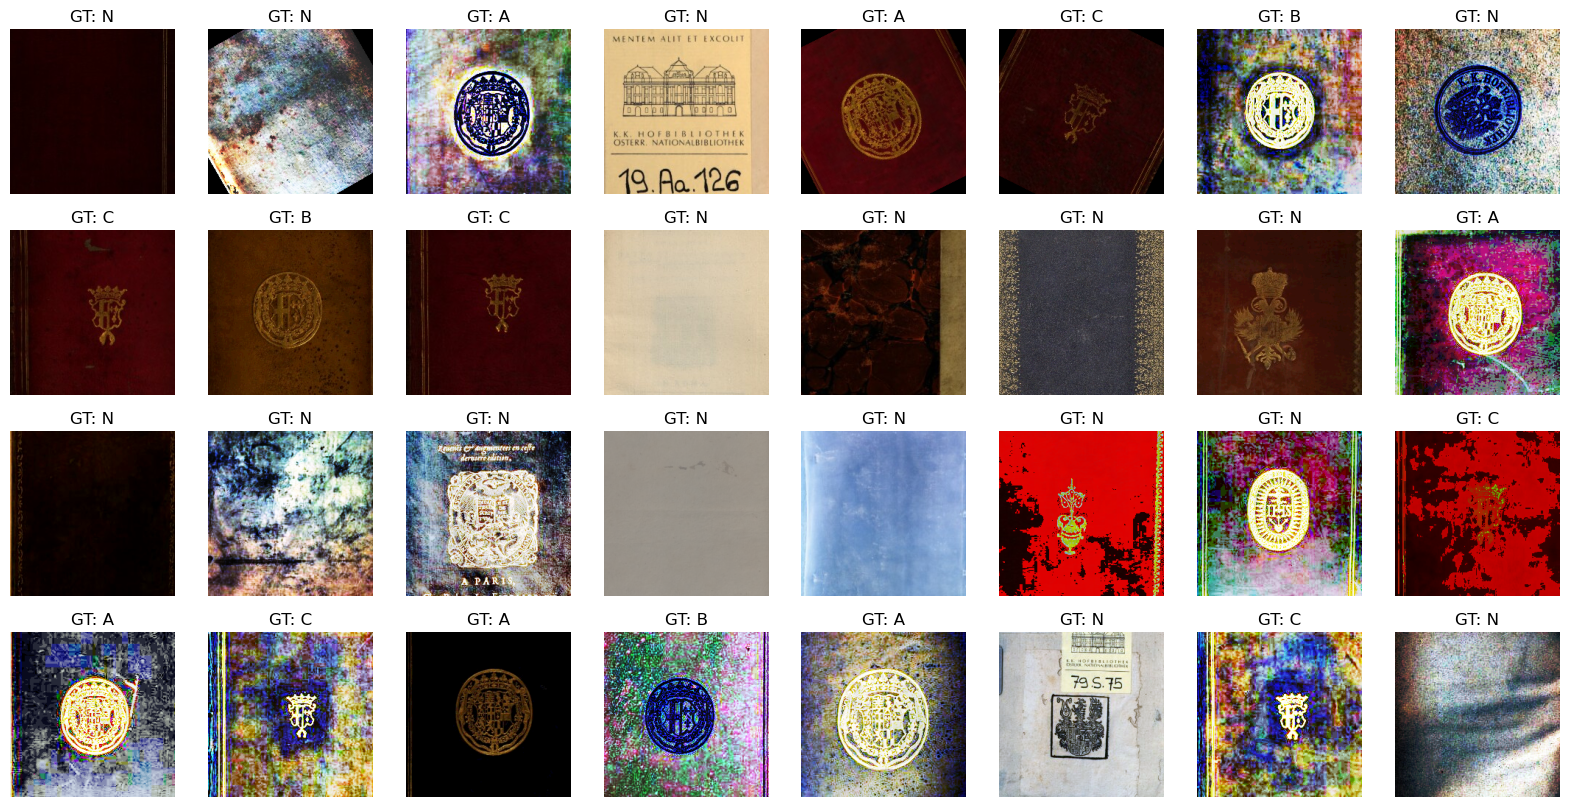

In [6]:
# def imshow(inp, title=None):
#     """Display image for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     # mean = np.array([0.485, 0.456, 0.406])
#     # mean = np.array([0.2138, 0.0986, 0.0467])
#     mean = np.array([0.3227, 0.2076, 0.1405])
    
#     # std = np.array([0.229, 0.224, 0.225])
#     # std = np.array([0.0856, 0.0697, 0.0405])
#     std = np.array([0.0816, 0.0715, 0.0502])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     # plt.pause(0.001)  # pause a bit so that plots are updated

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = m_np
    std = std_np
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    
def show_dataset(dataloader, num_images=16):
    images_so_far = 0
    cols = 8
    rows = int(np.ceil(num_images/cols))
    fig = plt.figure(figsize=(int(cols*2.5),int(rows*2.5)))
    
    for batch_idx, sample in enumerate(dataloader):
        images, labels = sample
        for i, image in enumerate(images):
            
            ax = plt.subplot(rows, cols, images_so_far + 1)
            ax.axis('off')
            ax.set_title(f"GT: {class_names[labels[i]]}")
            imshow(image)
            images_so_far += 1
        
            if images_so_far == num_images:
                return

show_dataset(dataloaders['train'], num_images=32)
plt.savefig('img/documentation/training_sample.jpg', bbox_inches='tight')

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [7]:
def visualize_model(model, num_images=8, data=dataloaders['val']):
    was_training = model.training
    model.eval()
    images_so_far = 0
    cols = 8
    rows = int(np.ceil(num_images/cols))
    fig = plt.figure(figsize=(int(cols*2.5),int(rows*2.5)))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(rows, cols, images_so_far)
                ax.axis('off')
                ax.set_title(f'GT: {class_names[labels[j]]}, predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnext50_32x4d(weights='DEFAULT')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.5536 Acc: 0.8064


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.1915 Acc: 0.9572

Epoch 1/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.1480 Acc: 0.9498


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.1209 Acc: 0.9737

Epoch 2/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0972 Acc: 0.9695


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0549 Acc: 0.9967

Epoch 3/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0588 Acc: 0.9835


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0407 Acc: 0.9967

Epoch 4/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0527 Acc: 0.9835


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0362 Acc: 0.9967

Epoch 5/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0346 Acc: 0.9918


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0280 Acc: 1.0000

Epoch 6/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0340 Acc: 0.9918


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0121 Acc: 1.0000

Epoch 7/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0278 Acc: 0.9942


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0360 Acc: 1.0000

Epoch 8/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0161 Acc: 0.9992


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0235 Acc: 1.0000

Epoch 9/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0144 Acc: 0.9942


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0269 Acc: 1.0000

Epoch 10/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0186 Acc: 0.9967


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0184 Acc: 1.0000

Epoch 11/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0269 Acc: 0.9942


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0294 Acc: 1.0000

Epoch 12/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0152 Acc: 0.9975


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0225 Acc: 1.0000

Epoch 13/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0178 Acc: 0.9951


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0329 Acc: 1.0000

Epoch 14/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0136 Acc: 0.9975


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0251 Acc: 1.0000

Epoch 15/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0096 Acc: 0.9984


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0347 Acc: 1.0000

Epoch 16/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0172 Acc: 0.9942


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0182 Acc: 1.0000

Epoch 17/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0142 Acc: 0.9959


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0354 Acc: 0.9967

Epoch 18/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0087 Acc: 0.9992


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0336 Acc: 1.0000

Epoch 19/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.9992


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0182 Acc: 1.0000

Epoch 20/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0176 Acc: 0.9959


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0168 Acc: 1.0000

Epoch 21/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0098 Acc: 0.9992


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0138 Acc: 1.0000

Epoch 22/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0124 Acc: 0.9967


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0231 Acc: 1.0000

Epoch 23/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0111 Acc: 0.9975


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0151 Acc: 1.0000

Epoch 24/24
----------


  0%|          | 0/304 [00:00<?, ?it/s]

train Loss: 0.0142 Acc: 0.9967


  0%|          | 0/76 [00:00<?, ?it/s]

val Loss: 0.0172 Acc: 1.0000

Training complete in 6m 49s
Best val Acc: 1.000000


In [11]:
torch.save(model_ft.state_dict(), 'models/final_GT_resnext50_32x4d_finetuned.pth')

In [10]:
model_ft.load_state_dict(torch.load('models/final_GT_resnext50_32x4d_finetuned.pth'))
model_ft.eval()
print()

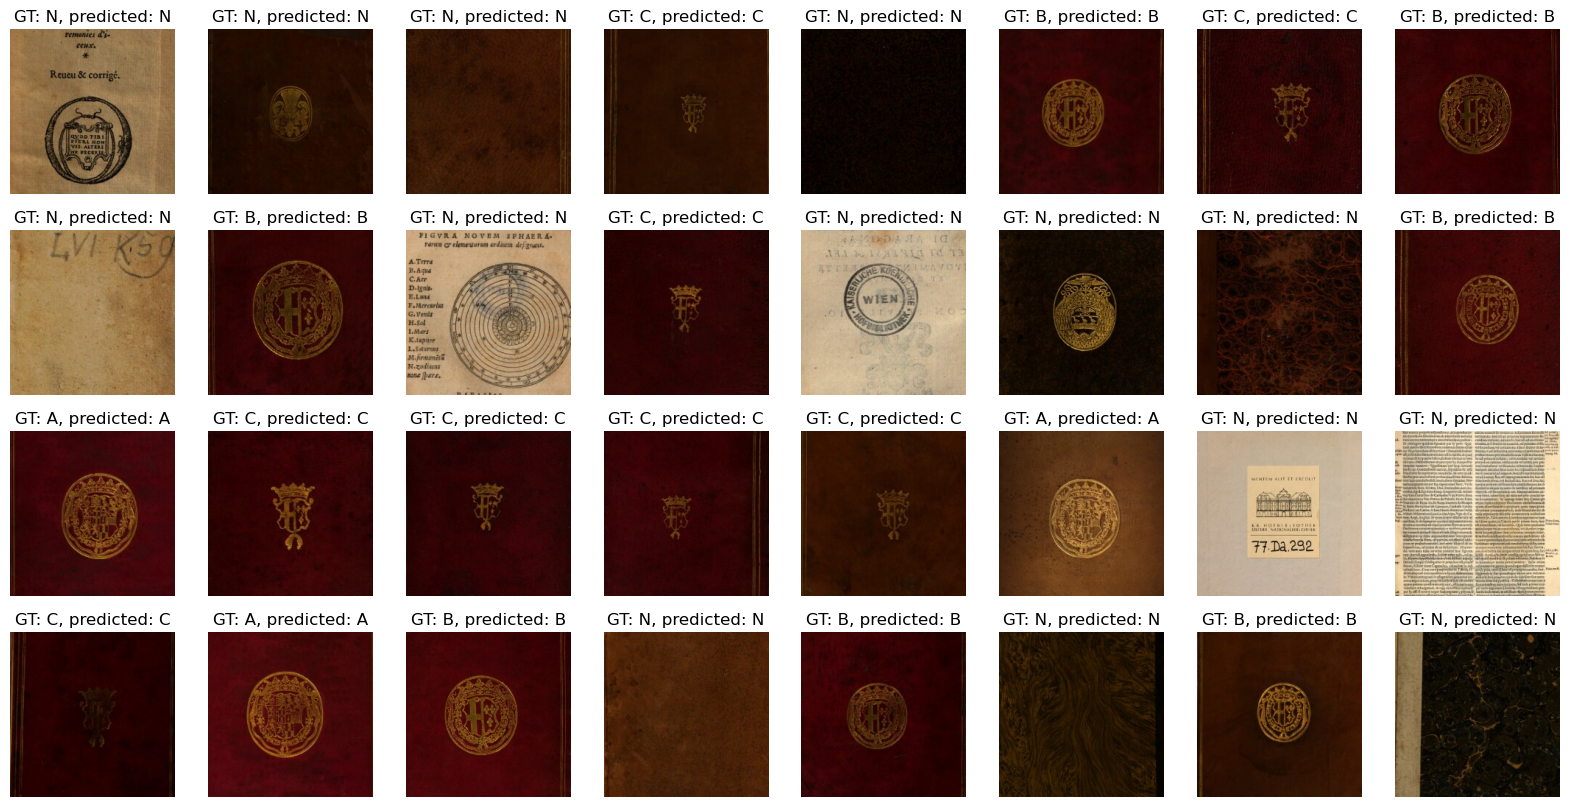

In [11]:
visualize_model(model_ft, num_images=32)
plt.savefig('img/documentation/validation_sample.jpg', bbox_inches='tight')

In [13]:
# data_dir = 'img/GT_cutout'
# image_dataset = datasets.ImageFolder(data_dir, data_transforms['val'])
# class_names = image_dataset.classes

add_dir = 'img/BED_testdata'
BED_add = datasets.ImageFolder(add_dir, data_transforms['val'])
BED_dl = torch.utils.data.DataLoader(BED_add, batch_size=4, num_workers=1)
print(len(BED_add))

11


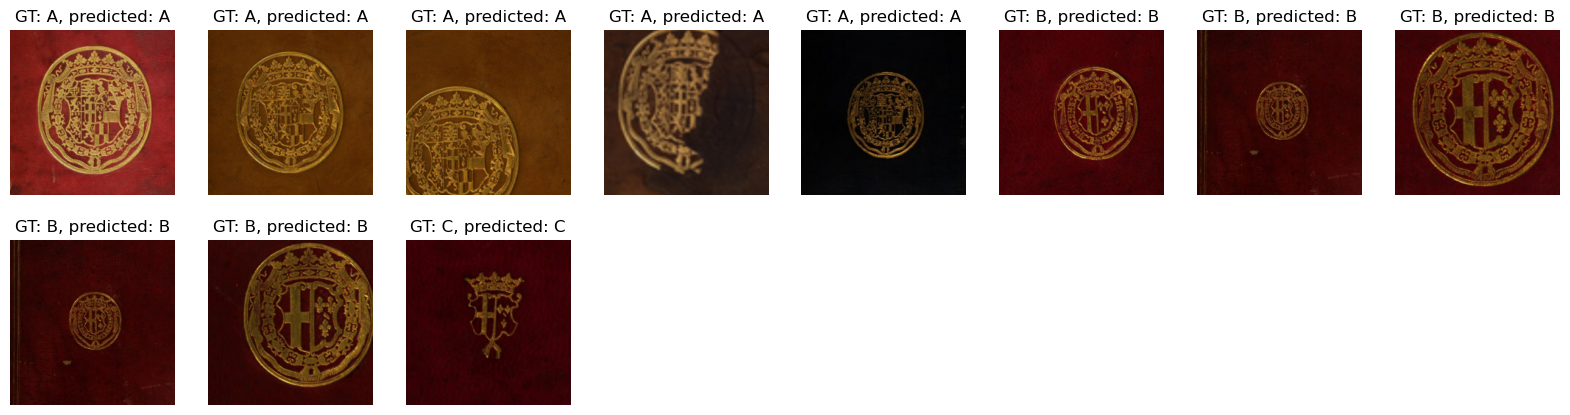

In [14]:
visualize_model(model_ft, num_images=len(BED_add), data=BED_dl)